<a href="https://colab.research.google.com/github/ryujiuno0323/troch_clover_data/blob/master/pytorch_transfer_clover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

このチュートリアルでは、転移学習を使用して画像分類のために畳み込みニューラルネットワークをトレーニングする方法を学習します。あなたはcs231nノートで転移学習についてもっと読むことができます
 <https://cs231n.github.io/transfer-learning/>

Quoting these notes,

実際には、十分なサイズのデータ​​セットを持つことは比較的まれであるため、（ランダム初期化を使用して）畳み込みネットワーク全体をゼロからトレーニングする人はほとんどいません。代わりに、非常に大規模なデータセット（1000のカテゴリを持つ120万の画像を含むImageNetなど）でConvNetを事前トレーニングし、ConvNetを初期化または目的のタスクの固定機能抽出として使用するのが一般的です。

これら2つの主要な転移学習シナリオは次のようになります。

<convnetの微調整>

ランダムな初期化の代わりに、imagenet 1000データセットでトレーニングされたような、事前トレーニングされたネットワークでネットワークを初期化します。残りのトレーニングは通常どおりです。

<固定機能抽出としてのConvNet>

ここでは、最後に完全に接続されたレイヤーを除くすべてのネットワークの重みを固定します。この最後に完全に接続されたレイヤーは、ランダムな重みを持つ新しいレイヤーに置き換えられ、このレイヤーのみがトレーニングされます。




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------
データのロードにはtorchvisionおよびtorch.utils.dataパッケージを使用します。

今日解決する問題は、アリとミツバチを分類するモデルをトレーニングすることです 。アリとミツバチのそれぞれに約120のトレーニング画像があります。各クラスには75の検証画像があります。通常、ゼロからトレーニングした場合、これは一般化する非常に小さなデータセットです。転移学習を使用しているので、かなり一般化できるはずです。

このデータセットは、imagenetの非常に小さなサブセットです。

ここからからデータをダウンロード し、現在のディレクトリに抽出します。
https://download.pytorch.org/tutorial/hymenoptera_data.zip

 

In [3]:
# download, decompress the data
#os.makedirs("data/hymenoptera_data", exist_ok=True)
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O /content/data/hymenoptera_data/hymenoptera_data.zip
#!unzip /content/data/hymenoptera_data/hymenoptera_data.zip  -d /content/data/ > /dev/null

#path to github
#https://github.com/ryujiuno0323/troch_clover_data.git

# pathto Gdrive, decompress the data
from google.colab import drive 
drive.mount('/content/drive')
#os.makedirs("data/troch_clover_data", exist_ok=True)
path_data="/content/drive/My Drive/aiapp/data/troch_clover_data/"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
p_temp=os.getcwd()
print(p_temp)
print(os.listdir(path=p_temp)) #取得したディレクトリの配下のディレクトリ確認
#p_temp="/content/data/hymenoptera_data/"
p_temp= path_data
print(p_temp)
print(os.listdir(path=p_temp)) #取得したディレクトリの配下のディレクトリ確認
p_temp= path_data+"train/"
print(p_temp)
print(os.listdir(path=p_temp)) #取得したディレクトリの配下のディレクトリ確認

/content
['.config', 'drive', 'sample_data']
/content/drive/My Drive/aiapp/data/troch_clover_data/
['val', 'train']
/content/drive/My Drive/aiapp/data/troch_clover_data/train/
['four', 'three']


In [5]:
#path = p_temp+"bees/"
path = p_temp+"four/"
print(path)
files = os.listdir(path)  #ファイ名とディレクトリ名の両方のリストが返る
count = len(files)  
print(count)
print(files)  
path = p_temp+"three/"
print(path)
files = os.listdir(path)  #ファイ名とディレクトリ名の両方のリストが返る
count = len(files)  
print(count)
print(files)  

/content/drive/My Drive/aiapp/data/troch_clover_data/train/four/
70
['010.jpg', '024.jpg', '015.jpg', '030.jpg', '022.jpg', '082.jpg', '035.jpg', '033.jpg', '080.jpg', '059.jpg', '064.jpg', '065.jpg', '003.jpg', '031.jpg', '049.jpg', '084.jpg', '041.jpg', '004.jpg', '042.jpg', '069.jpg', '083.jpg', '007.jpg', '076.jpg', '006.jpg', '028.jpg', '043.jpg', '067.jpg', '020.jpg', '002.jpg', '062.jpg', '057.jpg', '039.jpg', '073.jpg', '025.jpg', '050.jpg', '063.jpg', '068.jpg', '055.jpg', '051.jpg', '079.jpg', '070.jpg', '075.jpg', '016.jpg', '054.jpg', '012.jpg', '008.jpg', '023.jpg', '047.jpg', '017.jpg', '081.jpg', '013.jpg', '014.jpg', '061.jpg', '072.jpg', '036.jpg', '044.jpg', '071.jpg', '009.jpg', '058.jpg', '077.jpg', '045.jpg', '052.jpg', '018.jpg', '027.jpg', '034.jpg', '029.jpg', '005.jpg', '074.jpg', '056.jpg', 'resize']
/content/drive/My Drive/aiapp/data/troch_clover_data/train/three/
76
['041.jpg', '094.jpg', '039.jpg', '053.jpg', '083.jpg', '025.jpg', '059.jpg', '006.jpg', '009

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'data/hymenoptera_data'
data_dir = path_data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
print(image_datasets)
print(dataset_sizes)
print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 214
    Root location: /content/drive/My Drive/aiapp/data/troch_clover_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 33
    Root location: /content/drive/My Drive/aiapp/data/troch_clover_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': 214, 'val': 33}
['four', 'three']


#Visualize a few images

データ拡張を理解するために、いくつかのトレーニング画像を視覚化



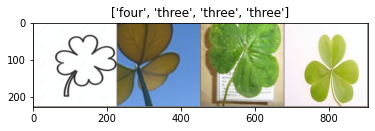

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

それでは、モデルをトレーニングするための一般的な関数を書いてみましょう。ここでは、次のことを説明します。

・学習率の設定
・最高のモデルを保存する

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
#25>15
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#Visualizing the model predictions　モデル予測の視覚化

いくつかの画像の予測を表示する汎用関数




In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------
事前学習済みモデルを読み込み、最終的に完全に接続されたレイヤーをリセット

Load a pretrained model and reset final fully connected layer.




In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


#Train and evaluate トレーニングと評価

CPUで約15〜25分かかります。GPUでは、1分程度





In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)
#25>50

Epoch 0/99
----------
train Loss: 0.6450 Acc: 0.6682
val Loss: 0.5780 Acc: 0.6667

Epoch 1/99
----------
train Loss: 0.6205 Acc: 0.7150
val Loss: 0.9735 Acc: 0.6364

Epoch 2/99
----------
train Loss: 0.6229 Acc: 0.7243
val Loss: 1.1240 Acc: 0.6061

Epoch 3/99
----------
train Loss: 0.6364 Acc: 0.7336
val Loss: 0.6760 Acc: 0.6970

Epoch 4/99
----------
train Loss: 0.5390 Acc: 0.7710
val Loss: 0.9944 Acc: 0.6970

Epoch 5/99
----------
train Loss: 0.4650 Acc: 0.7897
val Loss: 0.9578 Acc: 0.6970

Epoch 6/99
----------
train Loss: 0.5635 Acc: 0.7944
val Loss: 0.9670 Acc: 0.7273

Epoch 7/99
----------
train Loss: 0.4290 Acc: 0.8458
val Loss: 0.7377 Acc: 0.7879

Epoch 8/99
----------
train Loss: 0.4159 Acc: 0.8084
val Loss: 0.6293 Acc: 0.7576

Epoch 9/99
----------
train Loss: 0.3211 Acc: 0.8738
val Loss: 0.7877 Acc: 0.6667

Epoch 10/99
----------
train Loss: 0.3356 Acc: 0.8178
val Loss: 0.7134 Acc: 0.7273

Epoch 11/99
----------
train Loss: 0.3293 Acc: 0.8551
val Loss: 0.6402 Acc: 0.8182

Ep

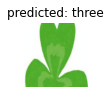

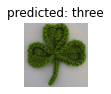

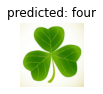

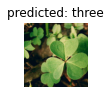

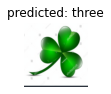

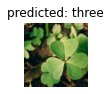

In [13]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------
ここでは、最終層を除くすべてのネットワークを凍結する必要があります

requires_grad == False　　　backward() 

詳しくは、こちらのドキュメントを ご覧ください。
https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward



In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#Train and evaluate トレーニングと評価

CPUでは、これは前のシナリオに比べて約半分の時間で済みます。ほとんどのネットワークで勾配を計算する必要がないので、これは予想されます。ただし、フォワードは計算する必要があります。




In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=100)
#25>15

Epoch 0/99
----------
train Loss: 0.6689 Acc: 0.6215
val Loss: 0.9993 Acc: 0.5152

Epoch 1/99
----------
train Loss: 0.8046 Acc: 0.6495
val Loss: 0.4871 Acc: 0.7576

Epoch 2/99
----------
train Loss: 0.6310 Acc: 0.7009
val Loss: 0.6780 Acc: 0.6970

Epoch 3/99
----------
train Loss: 0.5933 Acc: 0.7290
val Loss: 0.7044 Acc: 0.7576

Epoch 4/99
----------
train Loss: 0.4795 Acc: 0.7710
val Loss: 1.1852 Acc: 0.6061

Epoch 5/99
----------
train Loss: 0.6014 Acc: 0.7196
val Loss: 1.6449 Acc: 0.5152

Epoch 6/99
----------
train Loss: 0.5851 Acc: 0.7383
val Loss: 1.5241 Acc: 0.5455

Epoch 7/99
----------
train Loss: 0.4692 Acc: 0.8131
val Loss: 0.8566 Acc: 0.6667

Epoch 8/99
----------
train Loss: 0.4608 Acc: 0.7897
val Loss: 0.8719 Acc: 0.6364

Epoch 9/99
----------
train Loss: 0.4075 Acc: 0.8411
val Loss: 0.7199 Acc: 0.6364

Epoch 10/99
----------
train Loss: 0.4331 Acc: 0.7897
val Loss: 0.8275 Acc: 0.6970

Epoch 11/99
----------
train Loss: 0.4608 Acc: 0.7804
val Loss: 0.7901 Acc: 0.6061

Ep

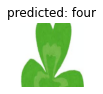

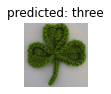

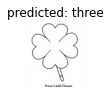

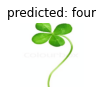

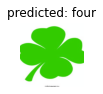

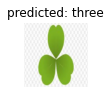

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#モデルを保存

In [17]:
# モデルの保存
#model=model_conv.to(device)
model=model_conv.to("cpu")
model.eval()
#サンプル入力サイズ
example = torch.randn(1, 3, 28, 28)
print(example.shape)
print(example)
#example =example.to(device)
example =example.to("cpu")
print(example.shape)
print(example)

traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("./resnet.pt")
print(model)

torch.Size([1, 3, 28, 28])
tensor([[[[ 0.4769,  0.7476, -1.9332,  ..., -0.7272, -0.7412,  1.1498],
          [-0.8135, -0.4611, -0.3535,  ...,  1.0997, -0.0846,  2.4822],
          [-0.0499,  0.2681,  1.4517,  ..., -0.3209, -0.0033,  1.1762],
          ...,
          [-0.6159,  2.1412, -0.7561,  ..., -0.7315, -1.8861,  0.3406],
          [-0.0563, -2.2739, -1.5491,  ..., -1.3924,  0.5514,  0.5367],
          [-0.9569, -0.9038,  0.3664,  ..., -1.2777,  1.8540, -0.5925]],

         [[-0.2248,  0.1983, -0.9011,  ..., -0.3632, -0.2177,  1.6976],
          [-0.4094, -0.2411,  0.8715,  ...,  0.2612,  1.6484,  0.5238],
          [ 0.0859, -1.3635, -1.2700,  ..., -0.1315, -1.6567,  1.3929],
          ...,
          [-0.0050,  0.8060,  1.6146,  ..., -0.6244, -1.1998,  1.7166],
          [-1.6589, -1.0537, -0.7193,  ..., -0.8258,  1.6251, -0.7106],
          [-0.6151,  2.5008,  2.0482,  ..., -0.7956, -0.8875, -0.9855]],

         [[-2.7498, -0.7370,  1.2815,  ...,  1.0783, -0.1284, -0.5183],
   

#モデルをダウンロード

In [18]:
import os

p_temp=os.getcwd()
print(p_temp)
#取得したディレクトリの配下のディレクトリ確認
print(os.listdir(path=p_temp))

/content
['.config', 'drive', 'resnet.pt', 'sample_data']


In [19]:
from google.colab import files
files.download('resnet.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#


In [20]:

#package com.example.realtimeimagerecognitionapp

#class ImageNetClasses {
#    var IMAGENET_CLASSES = arrayOf(
#        'ants', 'bees'
#         //略(githubからコピペしてください)
#    )
#}

class ImageNetClasses {
    var IMAGENET_CLASSES = arrayOf(
        'ants', 'bees'
         //略(githubからコピペしてください)
    )
}

Further Learning さらなる学習
-----------------

転移学習のアプリケーションの詳細については、コンピュータビジョンの量子化転移学習チュートリアルをご覧ください。

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial

https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html


